In [1]:
from pitas import power, flipper_tools
from orphics import maps as omaps
from pixell import enplot, enmap, curvedsky
import numpy as np
from cosmikyu import stats, mpi, datasets, config, utils, gan, transforms
from cosmikyu import nn as cnn
import os
from itertools import product
import healpy as hp
import matplotlib.pyplot as plt
import random
from minkfncts2d import MF2D
from itertools import cycle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
stat_dir = os.path.join(sehgal_dir, "stats")


#norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/281220_logz_normalization_info_validation.npz"
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
compts = ["kappa", "ksz", "tsz", "ir", "rad"]

plot_dir = "/home/dwhan89/scratch/outbox/cosmikyu"
def plot_path(x):
    return os.path.join(plot_dir, x)

In [12]:
overwrite=True
STAT_TEST = stats.STATS("281220_sehgal_cosmoganwgpv_minko", output_dir=stat_dir, overwrite=overwrite)
shape = (128,128)
SDS_test = datasets.SehgalDataSet(sehgal_dir, "test281220_fromcat", transforms=[SDN],
                                  dummy_label=False, dtype=np.float64, shape=(5,)+shape)
nsample = 50#len(SDS_test)

z = np.linspace(-15,15,300)
for i, compt in enumerate(compts):
    for j in range(nsample):
        if j % 100 == 0: print(compt, j)
        st_idx_temp = "%s_{}"%compt
        if STAT_TEST.has_data(st_idx_temp.format("chi"), j):
            continue
        storage = np.zeros((len(z),3))
        for k, threshold in enumerate(z):
            f, u, chi = MF2D((SDS_test[j][i]).astype(np.float), threshold)
            storage[k,:] = np.array([f, u, chi])
        STAT_TEST.add_data(st_idx_temp.format("f"), j, storage[:,0].copy())
        STAT_TEST.add_data(st_idx_temp.format("u"), j, storage[:,1].copy())    
        STAT_TEST.add_data(st_idx_temp.format("chi"), j, storage[:,2].copy())
            
STAT_TEST.add_data("z", 0, z)
ret = STAT_TEST.get_stats()    

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
kappa 0
ksz 0
tsz 0
ir 0
rad 0
[STATS] collecting data
[STATS] saving /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_281220_sehgal_cosmoganwgpv_minko.npz from root 0
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_281220_sehgal_cosmoganwgpv_minko.npz
calculating stats


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/dwhan89/workspace/cosmikyu/cosmikyu/stats.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(data.transpose(), ddof=ddof)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/d

In [13]:
STanh = cnn.ScaledTanh(15., 2./15.)
LF = cnn.LinearFeature(5,5)
MCM = transforms.MultiComptMultiply([1, 1, 1, 1, 1]  )

#norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
experiment_id = "5f8423937e6e4391a820aaf93ef55a21"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_dcganwgp_281220/{}/model".format(experiment_id)
print(model_dir)
latent_dim = 256
overwrite =True
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)
STAT_GEN = stats.STATS(experiment_id+"_minko", output_dir=stat_dir, overwrite=overwrite)
save_points = [30,31,70]#np.arange(44,52,2)
shape = (128,128)
nsample = 50

z = np.linspace(-15,15,300)
for save_point in save_points: 
    DCGAN_WGP = gan.DCGAN_WGP("sehgal_dcganwgp", (5,)+shape, latent_dim, cuda=False, nconv_fcgen=64,
                                      nconv_fcdis=64, ngpu=4, nconv_layer_gen=5, nconv_layer_disc=5, 
                              kernal_size=4, stride=2, padding=1, output_padding=0, gen_act=[LF,STanh])
    
    
    DCGAN_WGP.load_states(model_dir, "_{}".format(save_point))
    
    for i, compt in enumerate(compts):
        for j in range(nsample):
            if j % 6000 == 0: print(compt, j)
            st_idx_temp = "%s_%s_{}"%(compt, save_point)
            
            #if STAT_GEN.has_data(st_idx_temp.format("chi"), j):
                #continue
            
            sample = (MCM(DCGAN_WGP.generate_samples(1).data.numpy()[0].astype(np.float64)))
            #if j == 0: enplot.pshow(sample[i])
            plt.show()
            storage = np.zeros((len(z), 3))
            for k, threshold in enumerate(z):
                f, u, chi = MF2D(sample[i], threshold)
                storage[k,:] = np.array([f, u, chi])
            
            STAT_GEN.add_data(st_idx_temp.format("f"), j, storage[:,0].copy())
            STAT_GEN.add_data(st_idx_temp.format("u"), j, storage[:,1].copy())    
            STAT_GEN.add_data(st_idx_temp.format("chi"), j, storage[:,2].copy())

    STAT_GEN.add_data("z", 0, z)
ret = STAT_GEN.get_stats()  

Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


/home/dwhan89/workspace/cosmikyu/output/sehgal_dcganwgp_281220/5f8423937e6e4391a820aaf93ef55a21/model
[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _30
kappa 0
ksz 0
tsz 0
ir 0
rad 0


Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _31
kappa 0
ksz 0
tsz 0
ir 0
rad 0


Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _70
kappa 0
ksz 0
tsz 0
ir 0
rad 0
[STATS] collecting data
[STATS] saving /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_5f8423937e6e4391a820aaf93ef55a21_minko.npz from root 0
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_5f8423937e6e4391a820aaf93ef55a21_minko.npz
calculating stats


In [10]:
def key2label(key):
    storage = {"kappa":r"$  \kappa  $",
               "ksz":" kSZ ",
               "tsz":" tSZ ",
               "ir":" CIB ",
               "rad":"Radio",
              }
    return storage[key]

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:9: DeprecationWarning: invalid escape sequence \c
<>:9: DeprecationWarning: invalid escape sequence \c
<>:9: DeprecationWarning: invalid escape sequence \c
<ipython-input-18-77845209fca0>:9: DeprecationWarning: invalid escape sequence \c
  label="$\chi$ (Euler characteristic)", color="g")


<Figure size 432x288 with 0 Axes>

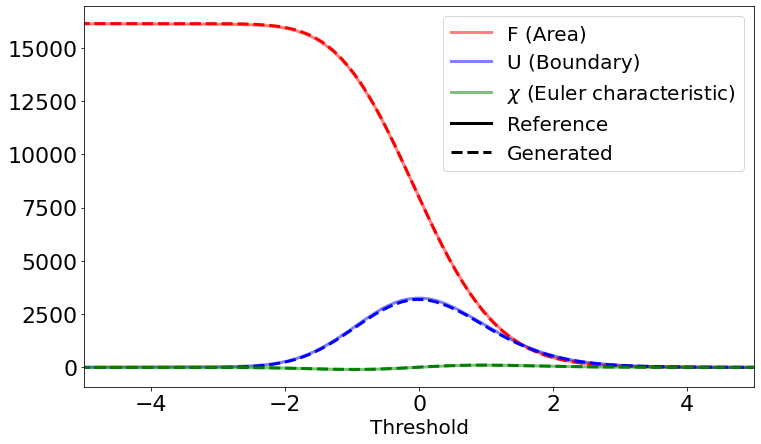

<Figure size 432x288 with 0 Axes>

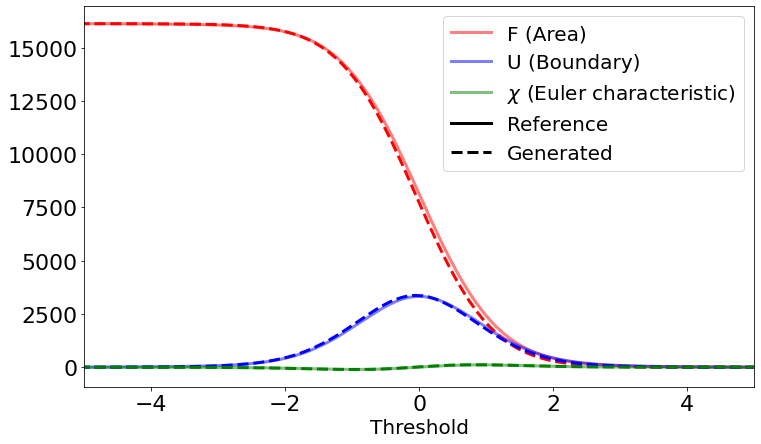

<Figure size 432x288 with 0 Axes>

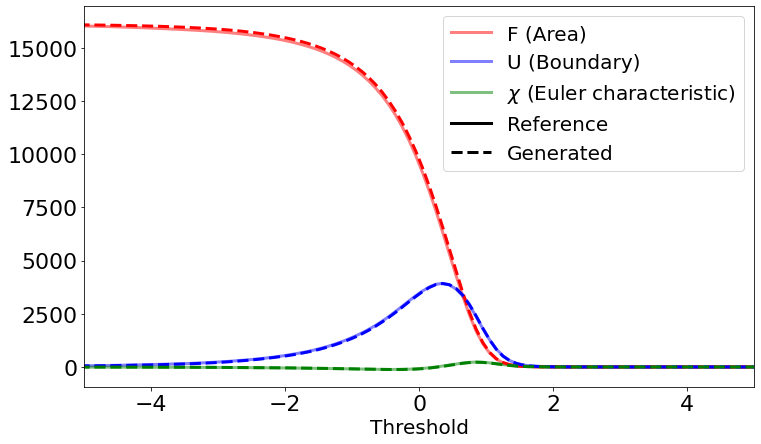

<Figure size 432x288 with 0 Axes>

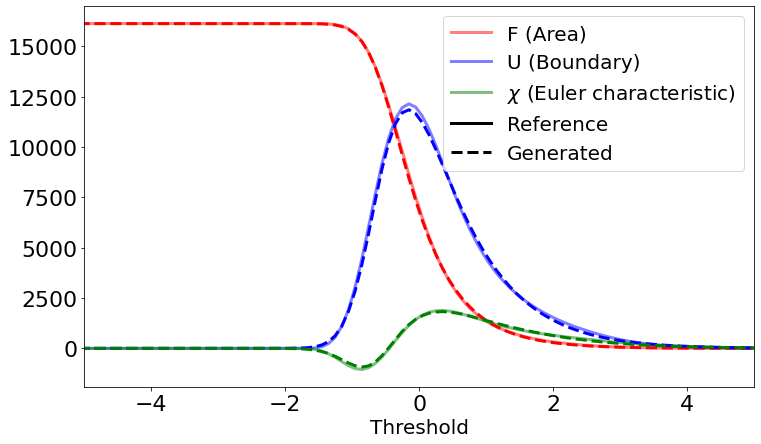

<Figure size 432x288 with 0 Axes>

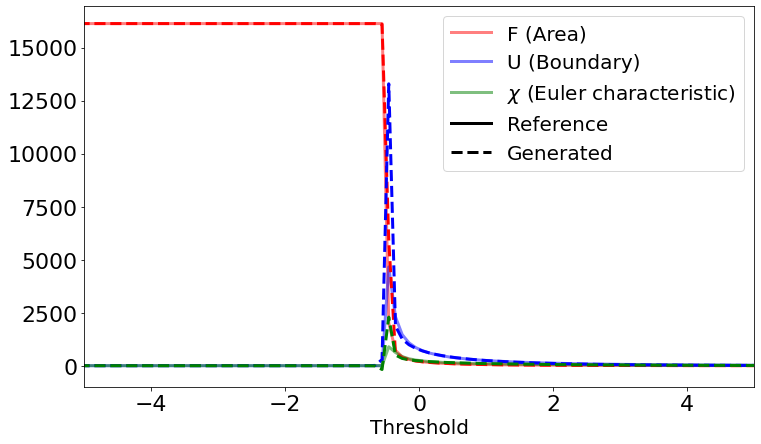

In [18]:

for i, compt in enumerate(compts):
    plt.clf()
    st_idx_temp = "%s_{}"%(compt)
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca()
    plt.plot(z, STAT_TEST.stats[st_idx_temp.format("f")]["mean"], alpha=0.5, lw=3, label="F (Area)", color="r")
    plt.plot(z, STAT_TEST.stats[st_idx_temp.format("u")]["mean"], alpha=0.5,lw=3, label="U (Boundary)", color="b")
    plt.plot(z, STAT_TEST.stats[st_idx_temp.format("chi")]["mean"], alpha=0.5,lw=3,
             label="$\chi$ (Euler characteristic)", color="g")
    st_idx_temp = "%s_%s_{}"%(compt, save_points[0])
    mean, std = STAT_GEN.stats[st_idx_temp.format("f")]["mean"], STAT_GEN.stats[st_idx_temp.format("f")]["std"]
    plt.plot(z, mean, ls="--", lw=3, color="r")
    mean, std = STAT_GEN.stats[st_idx_temp.format("u")]["mean"], STAT_GEN.stats[st_idx_temp.format("u")]["std"]
    plt.plot(z, mean, ls="--", lw=3, color="b")
    mean, std = STAT_GEN.stats[st_idx_temp.format("chi")]["mean"], STAT_GEN.stats[st_idx_temp.format("chi")]["std"]
    plt.plot(z, mean, ls="--", lw=3, color="g")
    plt.plot([],[], lw=3, color="k", label="Reference")
    plt.plot([],[], ls="--", lw=3, color="k", label="Generated")
    plt.xlim(-5,5)
    plt.yscale("linear")
    plt.legend(fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    plt.xlabel("Threshold", fontsize=20)
    plt.show()

0 0 0


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:11: DeprecationWarning: invalid escape sequence \c
<>:35: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
<>:35: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
<>:35: DeprecationWarning: invalid escape sequence \c
<ipython-input-17-200477c952cf>:11: DeprecationWarning: invalid escape sequence \c
  label="$\chi$ (Euler characteristic)", color="g")
<ipython-input-17-200477c952cf>:35: DeprecationWarning: invalid escape sequence \c
  axes[2,1].plot([],[], lw=3, color="g", label="$\chi$ (Euler characteristic)")


KeyError: 'kappa_f'

<Figure size 432x288 with 0 Axes>

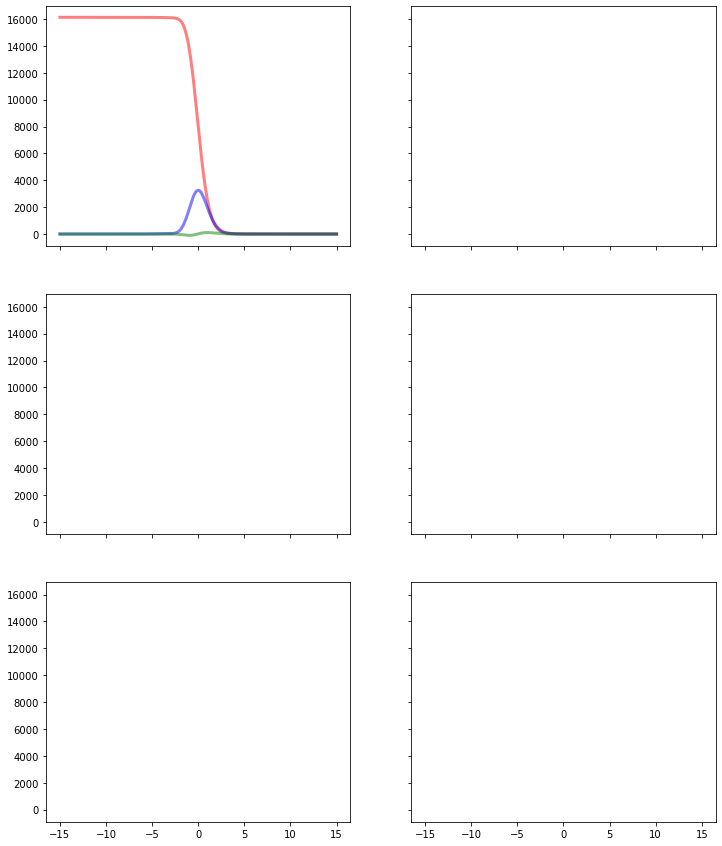

In [17]:
plt.clf()
fig, axes = plt.subplots(3,2, figsize=(12,15), sharex='all', sharey='all')
for i, compt in enumerate(compts):
    yidx = i // 2
    xidx = i % 2
    print(i, yidx, xidx)
    st_idx_temp = "%s_{}"%compt
    axes[yidx,xidx].plot(z, STAT_TEST.stats[st_idx_temp.format("f")]["mean"], alpha=0.5, lw=3, label="F (Area)", color="r")
    axes[yidx,xidx].plot(z, STAT_TEST.stats[st_idx_temp.format("u")]["mean"], alpha=0.5,lw=3, label="U (Boundary)", color="b")
    axes[yidx,xidx].plot(z, STAT_TEST.stats[st_idx_temp.format("chi")]["mean"], alpha=0.5,lw=3,
             label="$\chi$ (Euler characteristic)", color="g")
    
    mean, std = STAT_GEN.stats[st_idx_temp.format("f")]["mean"], STAT_GEN.stats[st_idx_temp.format("f")]["std"]
    axes[yidx,xidx].plot(z, mean, ls="--", lw=3, color="r")
    mean, std = STAT_GEN.stats[st_idx_temp.format("u")]["mean"], STAT_GEN.stats[st_idx_temp.format("u")]["std"]
    axes[yidx,xidx].plot(z, mean, ls="--", lw=3, color="b")
    mean, std = STAT_GEN.stats[st_idx_temp.format("chi")]["mean"], STAT_GEN.stats[st_idx_temp.format("chi")]["std"]
    axes[yidx,xidx].plot(z, mean, ls="--", lw=3, color="g")
    axes[yidx,xidx].set_xlim([-3,3])
    axes[yidx,xidx].set_ylim(-1000, 17000)
    axes[yidx,xidx].tick_params(axis='both', which='major', labelsize=25)
    axes[yidx,xidx].tick_params(axis='both', which='minor', labelsize=25)
    axes[yidx,xidx].grid()
    axes[yidx,xidx].text(0.90, 0.8, key2label(compt),
        verticalalignment='bottom', horizontalalignment='right',
        transform=axes[yidx,xidx].transAxes,
        color='k', fontsize=25, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.subplots_adjust(wspace=None, hspace=None)
    axes[yidx,xidx].set_xlabel("Threshold", fontsize=23)
    #plt.plot([],[], lw=3, color="k", label="Reference")
    #plt.plot([],[], ls="--", lw=3, color="k", label="Generated")
 
axes[2,1].plot([],[], lw=3, color="r", label="F (Area)")
axes[2,1].plot([],[], lw=3, color="b", label="U (Boundary)")
axes[2,1].plot([],[], lw=3, color="g", label="$\chi$ (Euler characteristic)")
axes[2,1].plot([],[], lw=3, color="k", label="Sehgal et al.")
axes[2,1].plot([],[], ls="--", lw=3, color="k", label="Network")
axes[2,1].tick_params(axis='both', which='major', labelsize=25)
axes[2,1].tick_params(axis='both', which='minor', labelsize=25)
axes[2,1].grid()
axes[2,1].set_xlabel("Threshold", fontsize=25)
axes[2,1].legend(fontsize=20)
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(plot_path("141020_minko.pdf"))
plt.show()